# Galaxy ML Testing

This notebook is a test of using machine learning models on the SDSS and 2MRS galaxy catalogs, looking particularly at local density.

In [1]:
#Imports
import scipy
import pandas as pd
import numpy as np
import sklearn
from pandas import read_csv
from matplotlib import pyplot as plt
import os
from google.colab import drive

#Model-assisting import
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

#Model imports

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/Physics Research/Fall 2024 Research')

Mounted at /content/drive/


In [2]:
#Reading the files
sdssFile = read_csv("EnvironmentsFromSDSS.csv")
mrsFile = read_csv("EnvironmentsFrom2MRS.csv")

print("SDSS File:\n")
print(sdssFile.head())
print("\n2MRS File:\n")
print(mrsFile.head())
print("\n\n\n")
print(f'SDSS File Shape: {sdssFile.shape}')
print(f'2MRS File Shape: {mrsFile.shape}')

SDSS File:

   GalaxyID         RA       Dec  Redshift  Local density  \
0        25  187.70593  12.39110   0.00544       4.785178   
1        62  189.43166  11.81809   0.00614       4.288702   
2       139  187.25011  13.97856   0.00511       2.519169   
3       163  187.50945  13.63645   0.00560       3.191392   
4       345  188.02586  11.17643   0.00557       3.645366   

   Distance from filament  Distance from tendril  TendrilID  TendrilNgals  
0               48.499309               0.616927         22            91  
1               46.550675               0.463943         22            91  
2               49.493190               0.781303         22            91  
3               48.061390               1.079201         22            91  
4               48.103909               0.472181         22            91  

2MRS File:

   GalaxyID         RA       Dec  Redshift  Local density  \
0       378  332.14288 -57.44259   0.00501       0.006582   
1     16929  178.55110   0.136

# Comparing SDSS & 2MRS Local Densities
This section uses a scatter plot and line of best fit to visualize the contrast between measured local desnity for galaxies in both the SDSS and 2MRS catalogs. As can be seen in the graph, the line of best fit shows higher local densities for galaxies in SDSS compared to the same ones in 2MRS. This makes sense due to SDSS being able to detect much fainter galaxies, thus increasing the ceiling for local density measurement.

What is interesting are all the data points above the best fit line (data points where the 2MRS density was higher). This seems contradictory to what should be expected with its lack of faint galaxy detection compared to SDSS.

In [ ]:
%matplotlib inline

Number of matched galaxies: 3456




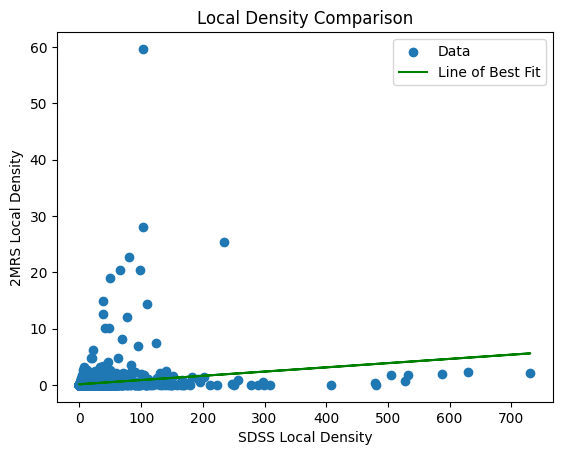

In [ ]:
###Graphing local densities

#Lists for local densities
sdssDens, mrsDens = np.array([]), np.array([])

#Matching galaxies in files
for sID, sDen in zip(sdssFile['GalaxyID'], sdssFile['Local density']):
  for mID, mDen in zip(mrsFile['GalaxyID'], mrsFile['Local density']):
    if sID == mID:
      sdssDens = np.append(sdssDens, [sDen])
      mrsDens = np.append(mrsDens, [mDen])
      break #jumps to next iteration of outer loop

print(f'Number of matched galaxies: {len(sdssDens)}\n\n')

# Calculate the line of best fit
slope, intercept = np.polyfit(sdssDens, mrsDens, 1)
best_fit_line = slope * sdssDens + intercept

#Plotting
plt.scatter(sdssDens, mrsDens, label='Data')       # Scatter plot of the original data
plt.plot(sdssDens, best_fit_line, color='green', label='Line of Best Fit')  # Line of best fit
plt.xlabel('SDSS Local Density')
plt.ylabel('2MRS Local Density')
plt.title('Local Density Comparison')
plt.legend()

plt.show()


 # Testing Models On SDSS File

 This section experiments on just the SDSS file for predicting local density.

 (MSE scoring measure might be good for when doing comparison between both files because it penalizes outliers)

In [ ]:
###Creating splits
vals = sdssFile.values
X = np.hstack((vals[:, 0:4], vals[:, 5:7])) # exlcudes TendrilID & TendrilNGals
y = vals[:,4] # local density

X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.20, random_state=1)

In [ ]:
###Local desnity SVM

# Initialize the SVM model
model = SVR(gamma='auto')

#kfold Cross Validation (with mean absolute percentage error)
kfold = KFold(n_splits=10, random_state=1, shuffle=True)
cvResult = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='neg_mean_absolute_percentage_error')

print(f'Mean absolute percentage error of SDSS SVM: {round(-cvResult.mean(), 2)}%')

Mean absolute percentage error of SDSS SVM: 2.46%


In [ ]:
###Local desnity with more models (to determine the best one)

# Initialize the models
models = []
models.append(('LR', LinearRegression()))
models.append(('RFR', RandomForestRegressor()))
models.append(('KNN', KNeighborsRegressor())) #default k is 5
models.append(('GBR', GradientBoostingRegressor()))
models.append(('SVM', SVR(gamma='auto')))

print('Model MAPEs:\n')
for name, model in models:
  kfold = KFold(n_splits=10, random_state=1, shuffle=True)
  cvResult = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='neg_mean_absolute_percentage_error')
  print(f'{name}: {round(-cvResult.mean(), 2)}%')


Model MAPEs:

LR: 19.22%
RFR: 13.12%
KNN: 12.51%
GBR: 15.2%
SVM: 2.46%


The result of cross validating 5 different models is that the SVM provided the lowest MAPE (mean average percentage error), meaning it performed the best at predicting local desnity where predicted values were roughly 3% innacurate on average. However, it peformed the best by far, with the next best model getting a percentage 11 points higher. Thus, all the other models performed poorly. I am curious at to whether the hyperparameters need to be tweaked, but the margin is so large that I believe the SVM model with remain the best.

In [ ]:
###Fitting on SVM
model = SVR(gamma='auto')
model.fit(X_train, Y_train)
predictions = model.predict(X_validation)

print(max(predictions))

#Evaluate predictions
print(f'Root Mean Squared Error: {root_mean_squared_error(Y_validation, predictions)}\n')
print(f'R^2 Score: {r2_score(Y_validation, predictions)}\n')

2.1297051183474114
Root Mean Squared Error: 28.893296504995654

R^2 Score: -0.10771395595134425



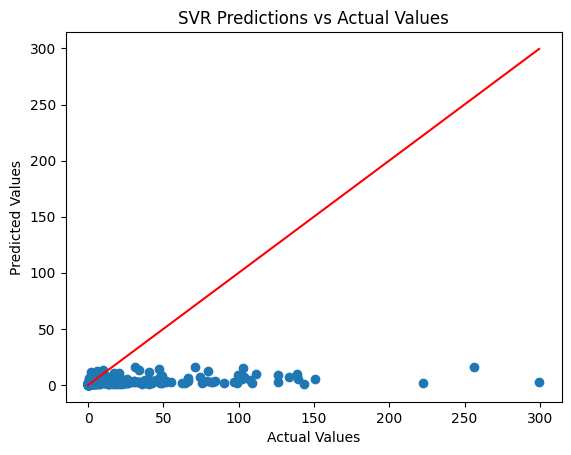

In [ ]:
###Plotting SVM Results
plt.scatter(Y_validation, predictions)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('SVR Predictions vs Actual Values')
plt.plot([min(Y_validation), max(Y_validation)], [min(Y_validation), max(Y_validation)], color='red')  # Ideal line
plt.show()

These results seem a little troubling. In order to evaluate what could be wrong, I tried addressing the actaul data I was using first. I decided to first eliminate the Galaxy ID column from the test data, as it doesn't really make sense in predicting anything about local denisty (or anything). This improved the cross-validation MAPE of all models slightly, and improved the prediction evaluation scores of the SVM model slightly.

In [ ]:
###Creating splits
vals = sdssFile.values
X = np.hstack((vals[:, 1:4], vals[:, 5:7])) # exlcudes GalaxyID!!!, TendrilID & TendrilNGals
y = vals[:,4] # local density

X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.20, random_state=1)

In [ ]:
###Local desnity with more models (to determine the best one)

# Initialize the models
models = []
models.append(('LR', LinearRegression()))
models.append(('RFR', RandomForestRegressor()))
models.append(('KNN', KNeighborsRegressor())) #default k is 5
models.append(('GBR', GradientBoostingRegressor()))
models.append(('SVM', SVR(gamma='auto')))

print('Model MAPEs:\n')
for name, model in models:
  kfold = KFold(n_splits=10, random_state=1, shuffle=True)
  cvResult = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='neg_mean_absolute_percentage_error')
  print(f'{name}: {round(-cvResult.mean(), 2)}%')


Model MAPEs:

LR: 19.22%
RFR: 13.14%
KNN: 12.51%
GBR: 15.16%
SVM: 2.46%


In [ ]:
###Fitting on SVM
model = SVR(gamma='auto')
model.fit(X_train, Y_train)
predictions = model.predict(X_validation)

print(max(predictions))

#Evaluate predictions
print(f'Root Mean Squared Error: {root_mean_squared_error(Y_validation, predictions)}\n')
print(f'R^2 Score: {r2_score(Y_validation, predictions)}\n')

16.02640711454561
Root Mean Squared Error: 27.879633087559302

R^2 Score: -0.03135349924657316



Next, I decided to purge the data further by eliminating the columns on distance to filament and distance to tendril. Professor Odekon said that she is skeptical of the reliability of these columns, so this could be affecting the predicted values. This finally gives a positive r-squared score (meaning that the model is finally better than just a horizontal line or mean of all the local densities), but it is only roughly 0.2 -- not great.

In [ ]:
###Creating splits
vals = sdssFile.values
X = vals[:, 1:4] # just RA, Dec, and Redshift
y = vals[:,4] # local density

X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.20, random_state=1)

In [ ]:
###Local desnity with more models (to determine the best one)

# Initialize the models
models = []
models.append(('LR', LinearRegression()))
models.append(('RFR', RandomForestRegressor()))
models.append(('KNN', KNeighborsRegressor())) #default k is 5
models.append(('GBR', GradientBoostingRegressor()))
models.append(('SVM', SVR(gamma='auto')))

print('Model MAPEs:\n')
for name, model in models:
  kfold = KFold(n_splits=10, random_state=1, shuffle=True)
  cvResult = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='neg_mean_absolute_percentage_error')
  print(f'{name}: {round(-cvResult.mean(), 2)}%')


Model MAPEs:

LR: 23.75%
RFR: 13.34%
KNN: 14.25%
GBR: 17.76%
SVM: 2.65%


In [ ]:
###Fitting on SVM
model = SVR(gamma='auto')
model.fit(X_train, Y_train)
predictions = model.predict(X_validation)

print(max(predictions))

#Evaluate predictions
print(f'Root Mean Squared Error: {root_mean_squared_error(Y_validation, predictions)}\n')
print(f'R^2 Score: {r2_score(Y_validation, predictions)}\n')

23.6992867928687
Root Mean Squared Error: 27.18752918538219

R^2 Score: 0.01921702239385259



Some further solutions to try would be handling outliers in the data (potentially everything over 150 local density or even lower), converting RA and Dec to Cartesian coordinates, exploring interactive terms, and considering log transformations for potentially non-linear relationships (distance to filament/distance to tendril and local density??? -- can plot to determine this better)

Could also be interesting to look at how hyperparameter k is affecting prediction evaulation scores (see CS276 lab for reference)

# Prediction of 2MRS Local Density using SDSS & 2MRS Overlap

In this section, I explore the use of regression models in predicting a more detailed or accurate local density measure for galaxies in the non-overlap region of the 2MRS survey trained on data from the overlap between 2MRS and SDSS galaxies.

In [ ]:
###Create and export merged and pruned dataset on overlap region

merged_table = pd.merge(sdssFile, mrsFile, on = 'GalaxyID')

#Get rid of unnecessary columns
merged_table = merged_table.drop(['RA_y', 'Dec_y', 'Redshift_y', 'Distance from filament_y', 'Distance from tendril_y', 'TendrilID_y', 'TendrilNgals_y', 'TendrilID_x', 'TendrilNgals_x'], axis=1)

#Rename columns (given _x | _y suffix due to pandas merge)
merged_table.rename(columns={'RA_x': 'RA'}, inplace=True)
merged_table.rename(columns={'Dec_x': 'Dec'}, inplace=True)
merged_table.rename(columns={'Redshift_x': 'Redshift'}, inplace=True)
merged_table.rename(columns={'Local density_x': 'SDSS Local Density'}, inplace=True)
merged_table.rename(columns={'Distance from filament_x': 'Distance From Filament'}, inplace=True)
merged_table.rename(columns={'Distance from tendril_x': 'Distance From Tendril'}, inplace=True)
merged_table.rename(columns={'Local density_y': '2MRS Local Density'}, inplace=True)

#Swap locations of SDSS and 2MRS Local Density columns (SDSS will be target feature so seems more appealing)
cols = list(merged_table.columns)
cols[4], cols[7] = cols[7], cols[4]
merged_table = merged_table[cols]

#Shows snippet of data table
print(merged_table.head())

merged_table.to_csv('merged_SDSS_2MRS_data.csv', index = False, header = True)


   GalaxyID         RA       Dec  Redshift  2MRS Local Density  \
0        25  187.70593  12.39110   0.00544            0.817944   
1        62  189.43166  11.81809   0.00614            0.550502   
2       139  187.25011  13.97856   0.00511            0.501012   
3       163  187.50945  13.63645   0.00560            0.727121   
4       345  188.02586  11.17643   0.00557            0.831199   

   Distance From Filament  Distance From Tendril  SDSS Local Density  
0               48.499309               0.616927            4.785178  
1               46.550675               0.463943            4.288702  
2               49.493190               0.781303            2.519169  
3               48.061390               1.079201            3.191392  
4               48.103909               0.472181            3.645366  


In [3]:
###Data from merged table
merged_csv = read_csv("merged_SDSS_2MRS_data.csv")
merged_csv.head()

,GalaxyID,RA,Dec,Redshift,2MRS Local Density,Distance From Filament,Distance From Tendril,SDSS Local Density
0,25,187.70593,12.39110,0.00544,0.817944,48.499309,0.616927,4.785178
1,62,189.43166,11.81809,0.00614,0.550502,46.550675,0.463943,4.288702
2,139,187.25011,13.97856,0.00511,0.501012,49.493190,0.781303,2.519169
3,163,187.50945,13.63645,0.00560,0.727121,48.061390,1.079201,3.191392
4,345,188.02586,11.17643,0.00557,0.831199,48.103909,0.472181,3.645366


In [ ]:
###Creating splits
vals = merged_csv.values
X = vals[:, 1:5] # RA, Dec, Redshift, & 2MRS Local Density
y = vals[:,7] # SDSS Local Density

X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.20, random_state=1)

In [ ]:
###K-Fold Cross-Validation To Compare Models

# Initialize the models
models = []
models.append(('LR', LinearRegression()))
models.append(('RFR', RandomForestRegressor()))
models.append(('KNN', KNeighborsRegressor())) #default k is 5
models.append(('GBR', GradientBoostingRegressor()))
models.append(('SVM', SVR(gamma='auto')))

print('Model MAPEs:\n')
for name, model in models:
  kfold = KFold(n_splits=10, random_state=1, shuffle=True)
  cvResult = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='neg_mean_absolute_percentage_error')
  print(f'{name}: {round(-cvResult.mean(), 2)}%')


Model MAPEs:

LR: 21.33%
RFR: 11.94%
KNN: 14.06%
GBR: 13.67%
SVM: 2.67%


Again, the SVM appears to be the best by far (this makes sense since the data is very similar to before just with the addition of the 2MRS local density as a feature)

In [ ]:
###Predicting on "more detailed" 2MRS local density with SVM
model = SVR(gamma='auto')
model.fit(X_train, Y_train)
predictions = model.predict(X_validation)

#print(max(predictions))

#Evaluate predictions
print(f'Root Mean Squared Error: {root_mean_squared_error(Y_validation, predictions)}\n')
print(f'R^2 Score: {r2_score(Y_validation, predictions)}\n')
print(f'MAPE Score: {round(mean_absolute_percentage_error(Y_validation, predictions), 2)}%\n')

Root Mean Squared Error: 27.385302752914708

R^2 Score: 0.004895863034644288

MAPE Score: 2.69%



In [ ]:
###Predicting on "more detailed" 2MRS local density with RFR
model = RandomForestRegressor()
model.fit(X_train, Y_train)
predictions = model.predict(X_validation)

#print(max(predictions))

#Evaluate predictions
print(f'Root Mean Squared Error: {root_mean_squared_error(Y_validation, predictions)}\n')
print(f'R^2 Score: {r2_score(Y_validation, predictions)}\n')
print(f'MAPE Score: {round(mean_absolute_percentage_error(Y_validation, predictions), 2)}%\n')

Root Mean Squared Error: 29.363630855213643

R^2 Score: -0.1440709284419266

MAPE Score: 10.88%



In [ ]:
###Predicting on "more detailed" 2MRS local density with GBR
model = GradientBoostingRegressor()
model.fit(X_train, Y_train)
predictions = model.predict(X_validation)

#print(max(predictions))

#Evaluate predictions
print(f'Root Mean Squared Error: {root_mean_squared_error(Y_validation, predictions)}\n')
print(f'R^2 Score: {r2_score(Y_validation, predictions)}\n')
print(f'MAPE Score: {round(mean_absolute_percentage_error(Y_validation, predictions), 2)}%\n')

Root Mean Squared Error: 33.632599493366975

R^2 Score: -0.5009088205567154

MAPE Score: 13.26%



As can be seen, all three models are failing to establish a viable relationship within the data.

One potential issue with my approach is that the data isn't normalized. There are many different scales across the input features, so normalizing the data can help the model better understand the input data.

In [ ]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler() # better for data with outliers

# Fit and transform the data
X_train_rscaled = scaler.fit_transform(X_train)
X_validation_rscaled = scaler.fit_transform(X_validation)

In [ ]:
###Predicting on "more detailed" 2MRS local density with SVM (with robust scaled data)
model = SVR(gamma='auto')
model.fit(X_train_rscaled, Y_train)
predictions = model.predict(X_validation_rscaled)

#print(max(predictions))

#Evaluate predictions
print(f'Root Mean Squared Error: {root_mean_squared_error(Y_validation, predictions)}\n')
print(f'R^2 Score: {r2_score(Y_validation, predictions)}\n')
print(f'MAPE Score: {round(mean_absolute_percentage_error(Y_validation, predictions), 2)}%\n')

Root Mean Squared Error: 27.708739917416228

R^2 Score: -0.01874852078646705

MAPE Score: 1.68%



In [ ]:
###Predicting on "more detailed" 2MRS local density with RFR (with robust scaled data)
model = RandomForestRegressor()
model.fit(X_train_rscaled, Y_train)
predictions = model.predict(X_validation_rscaled)

#print(max(predictions))

#Evaluate predictions
print(f'Root Mean Squared Error: {root_mean_squared_error(Y_validation, predictions)}\n')
print(f'R^2 Score: {r2_score(Y_validation, predictions)}\n')
print(f'MAPE Score: {round(mean_absolute_percentage_error(Y_validation, predictions), 2)}%\n')

Root Mean Squared Error: 26.955230275379748

R^2 Score: 0.03590566434249254

MAPE Score: 15.18%



In [ ]:
###Predicting on "more detailed" 2MRS local density with GBR (with robust scaled data)
model = GradientBoostingRegressor()
model.fit(X_train_rscaled, Y_train)
predictions = model.predict(X_validation_rscaled)

#print(max(predictions))

#Evaluate predictions
print(f'Root Mean Squared Error: {root_mean_squared_error(Y_validation, predictions)}\n')
print(f'R^2 Score: {r2_score(Y_validation, predictions)}\n')
print(f'MAPE Score: {round(mean_absolute_percentage_error(Y_validation, predictions), 2)}%\n')

Root Mean Squared Error: 27.213666213705913

R^2 Score: 0.017330343070037113

MAPE Score: 14.86%



In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() # standard scaling, best for data with Gaussian distribution

# Fit and transform the data
X_train_sscaled = scaler.fit_transform(X_train)
X_validation_sscaled = scaler.fit_transform(X_validation)

In [ ]:
###Predicting on "more detailed" 2MRS local density with SVM (with standard scaled data)
model = SVR(gamma='auto')
model.fit(X_train_sscaled, Y_train)
predictions = model.predict(X_validation_sscaled)

#print(max(predictions))

#Evaluate predictions
print(f'Root Mean Squared Error: {root_mean_squared_error(Y_validation, predictions)}\n')
print(f'R^2 Score: {r2_score(Y_validation, predictions)}\n')
print(f'MAPE Score: {round(mean_absolute_percentage_error(Y_validation, predictions), 2)}%\n')

Root Mean Squared Error: 27.914620316915073

R^2 Score: -0.033943694249591205

MAPE Score: 2.85%



Scaling the data failed to improve the results signifcantly enough. Next, I would like to try eliminating outliers in the data. Also, might be time to address faults in the data itself.

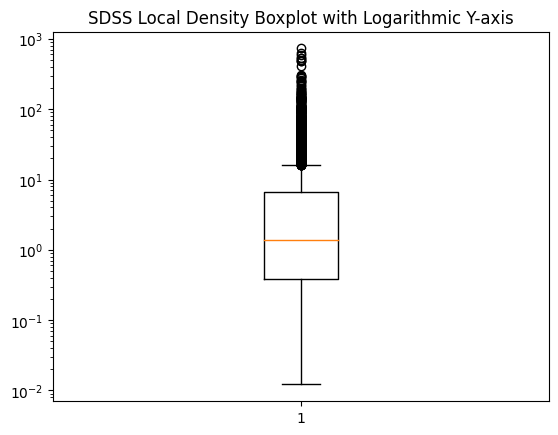

In [ ]:
###SDSS Local Density Boxplot
plt.boxplot(merged_csv['SDSS Local Density'])
plt.yscale('log')
plt.title('SDSS Local Density Boxplot with Logarithmic Y-axis')
plt.show()

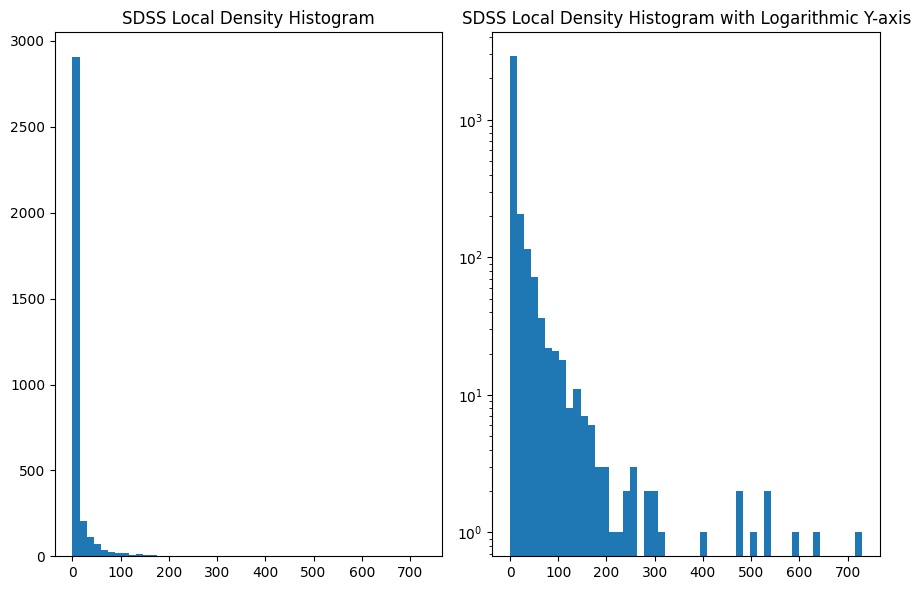

Some analysis:
Number of local densities in the first bin: 2905.0 out of 3456.0 total
The range of values in the first bin are: 0.0122 to 14.63


In [ ]:
###SDSS Local Density Histogram

plt.figure(figsize=(9, 6))

plt.subplot(1, 2, 1)
plt.hist(merged_csv['SDSS Local Density'], bins = 50)
plt.title('SDSS Local Density Histogram')

plt.subplot(1, 2, 2)
counts, bin_edges, _  = plt.hist(merged_csv['SDSS Local Density'], bins = 50)
plt.yscale('log')
plt.title('SDSS Local Density Histogram with Logarithmic Y-axis')

plt.tight_layout()
plt.show()

print('Some analysis:')
print(f'Number of local densities in the first bin: {counts[0]} out of {sum(counts)} total')
print(f'The range of values in the first bin are: {round(bin_edges[0], 4)} to {round(bin_edges[1], 2)}')



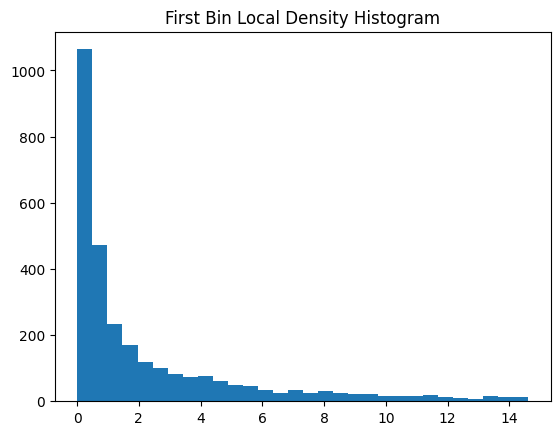

Further analysis:
Number of local densities in the first bin of the first bin: 1064.0 out of 2905.0 total
The range of values in the first bin of the first bin are: 0.0122 to 0.5


In [ ]:
###Zooming in on the first bin...
local_dens = merged_csv['SDSS Local Density'].to_numpy()
first_bin = local_dens[local_dens < 14.63] # boolean indexing

counts, bin_edges, _ = plt.hist(first_bin, bins = 30)
plt.title('First Bin Local Density Histogram')
plt.show()

print('Further analysis:')
print(f'Number of local densities in the first bin of the first bin: {counts[0]} out of {sum(counts)} total')
print(f'The range of values in the first bin of the first bin are: {round(bin_edges[0], 4)} to {round(bin_edges[1], 2)}')

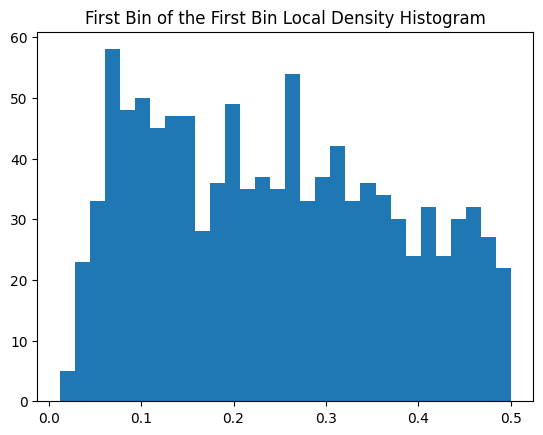

Final analysis:
Mean of all local densities: 11.76
Mean of first bin local densities: 2.31
Mean of first bin of first bin local densities: 0.24


In [ ]:
###Zooming in on first bin of first bin...
child_first_bin = first_bin[first_bin < 0.5]

counts, bin_edges, _ = plt.hist(child_first_bin, bins = 30)
plt.title('First Bin of the First Bin Local Density Histogram')
plt.show()

print('Final analysis:')
#Note: Different uses of mean due to Pandas DF & Numpy Array
print(f"Mean of all local densities: {round(merged_csv['SDSS Local Density'].mean(), 2)}")
print(f"Mean of first bin local densities: {round(np.mean(first_bin), 2)}")
print(f"Mean of first bin of first bin local densities: {round(np.mean(child_first_bin), 2)}")

While this analysis is kind of silly, it shows just how skewed the data is and just hot important pruning the data for outliers will be.

Since the data is HEAVILY skewed, it is suggested to first try the IQR method and then potentially considering the modified Z-score. Applying a log transformation could also be helpful for these methods since the data is so skewed.

In [ ]:
###Handling outliers using IQR Method
# Calculate IQR
Q1 = merged_csv['SDSS Local Density'].quantile(0.25)
Q3 = merged_csv['SDSS Local Density'].quantile(0.75)
IQR = Q3 - Q1

# Determine outlier thresholds
# A smaller multiplier than 1.5 would identify more outliers and vice versa
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers_iqr = merged_csv[(merged_csv['SDSS Local Density'] < lower_bound) |
                           (merged_csv['SDSS Local Density'] > upper_bound)]
print(outliers_iqr.shape)

# New pruned merged data
merged_csv_pruned = merged_csv[(merged_csv['SDSS Local Density'] >= lower_bound) &
                               (merged_csv['SDSS Local Density'] <= upper_bound)]
print(merged_csv_pruned.shape)


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-bc5d3533727c>", line 3, in <cell line: 3>
    Q1 = merged_csv['SDSS Local Density'].quantile(0.25)
NameError: name 'merged_csv' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python

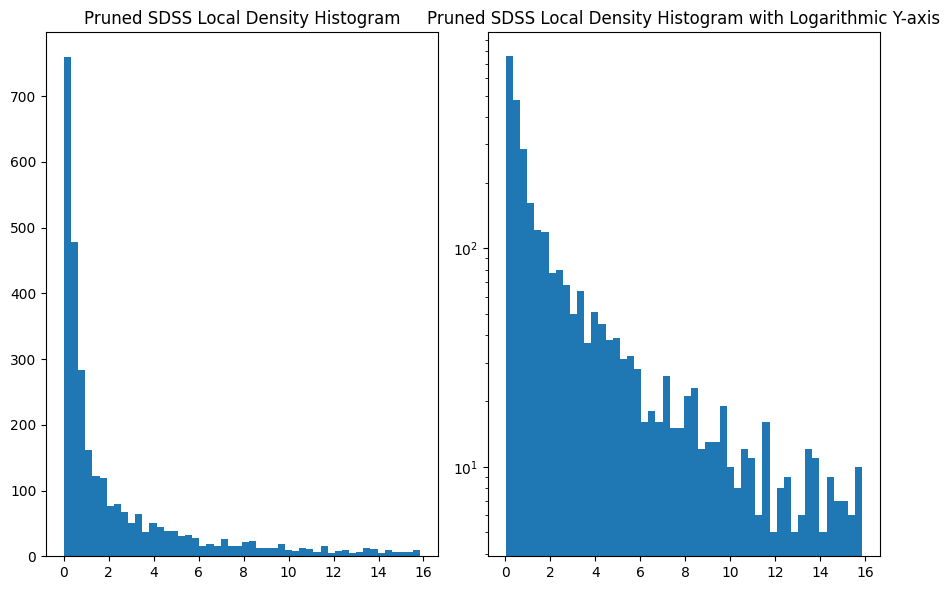

In [ ]:
###Histogram for the pruned data using the IQR method

plt.figure(figsize=(9, 6))

plt.subplot(1, 2, 1)
plt.hist(merged_csv_pruned['SDSS Local Density'], bins = 50)
plt.title('Pruned SDSS Local Density Histogram')

plt.subplot(1, 2, 2)
counts, bin_edges, _  = plt.hist(merged_csv_pruned['SDSS Local Density'], bins = 50)
plt.yscale('log')
plt.title('Pruned SDSS Local Density Histogram with Logarithmic Y-axis')

plt.tight_layout()
plt.show()

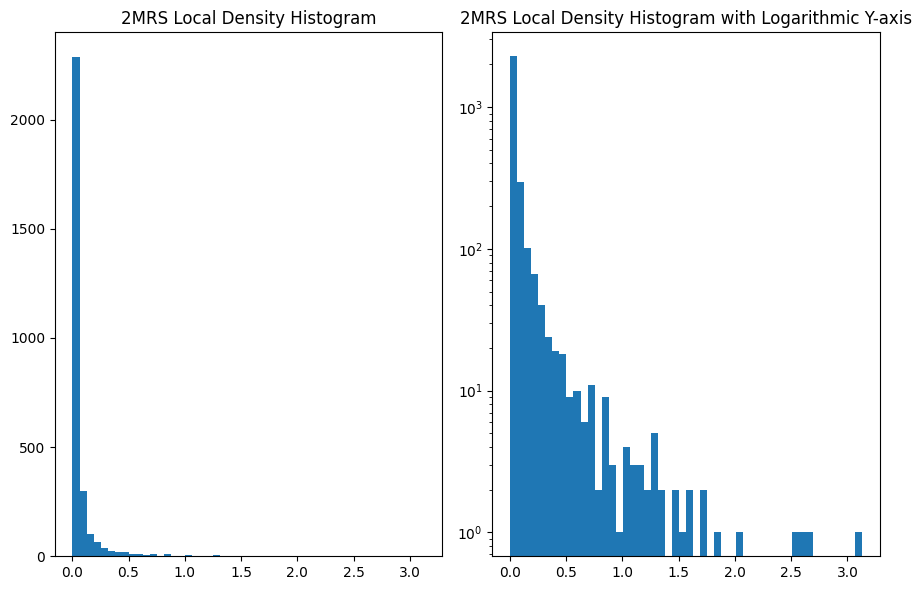

In [ ]:
###2MRS Local Density Histogram

plt.figure(figsize=(9, 6))

plt.subplot(1, 2, 1)
plt.hist(merged_csv_pruned['2MRS Local Density'], bins = 50)
plt.title('2MRS Local Density Histogram')

plt.subplot(1, 2, 2)
counts, bin_edges, _  = plt.hist(merged_csv_pruned['2MRS Local Density'], bins = 50)
plt.yscale('log')
plt.title('2MRS Local Density Histogram with Logarithmic Y-axis')

plt.tight_layout()
plt.show()

2MRS is still skewed, so want to also consider this feature in determining outliers.

In [4]:
###Handling outliers using IQR Method
# Calculate IQR for SDSS
Q1_sdss = merged_csv['SDSS Local Density'].quantile(0.25)
Q3_sdss = merged_csv['SDSS Local Density'].quantile(0.75)
IQR_sdss = Q3_sdss - Q1_sdss

# Determine outlier thresholds
# A smaller multiplier than 1.5 would identify more outliers and vice versa
lower_bound_sdss = Q1_sdss - 1.5 * IQR_sdss
upper_bound_sdss = Q3_sdss + 1.5 * IQR_sdss

# Calculate IQR for 2MRS
Q1_2mrs = merged_csv['2MRS Local Density'].quantile(0.25)
Q3_2mrs = merged_csv['2MRS Local Density'].quantile(0.75)
IQR_2mrs = Q3_2mrs - Q1_2mrs

# Determine outlier thresholds
# A smaller multiplier than 1.5 would identify more outliers and vice versa
lower_bound_2mrs = Q1_2mrs - 1.5 * IQR_2mrs
upper_bound_2mrs = Q3_2mrs + 1.5 * IQR_2mrs

# Identify SDSS outliers
outliers_iqr_sdss = merged_csv[(merged_csv['SDSS Local Density'] < lower_bound_sdss) |
                           (merged_csv['SDSS Local Density'] > upper_bound_sdss)]
print(outliers_iqr_sdss.shape)

# Identify 2MRS outliers
outliers_iqr_2mrs = merged_csv[(merged_csv['2MRS Local Density'] < lower_bound_2mrs) |
                           (merged_csv['2MRS Local Density'] > upper_bound_2mrs)]
print(outliers_iqr_2mrs.shape)

# Creating the pruned data based on both local desnity features
final_iqr_pruned_data  = merged_csv[(merged_csv['SDSS Local Density'] >= lower_bound_sdss) &
                                (merged_csv['SDSS Local Density'] <= upper_bound_sdss) &
                                (merged_csv['2MRS Local Density'] >= lower_bound_2mrs) &
                                (merged_csv['2MRS Local Density'] <= upper_bound_2mrs)]

print(final_iqr_pruned_data.shape)

(522, 8)
(494, 8)
(2636, 8)


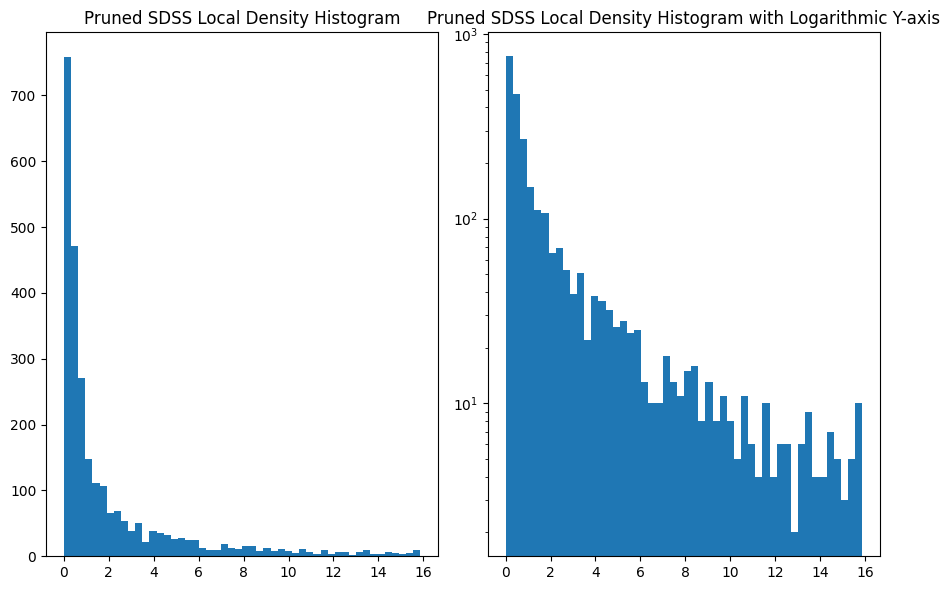

In [ ]:
###Histogram for the pruned data using the IQR method

plt.figure(figsize=(9, 6))

plt.subplot(1, 2, 1)
plt.hist(final_iqr_pruned_data['SDSS Local Density'], bins = 50)
plt.title('Pruned SDSS Local Density Histogram')

plt.subplot(1, 2, 2)
counts, bin_edges, _  = plt.hist(final_iqr_pruned_data['SDSS Local Density'], bins = 50)
plt.yscale('log')
plt.title('Pruned SDSS Local Density Histogram with Logarithmic Y-axis')

plt.tight_layout()
plt.show()

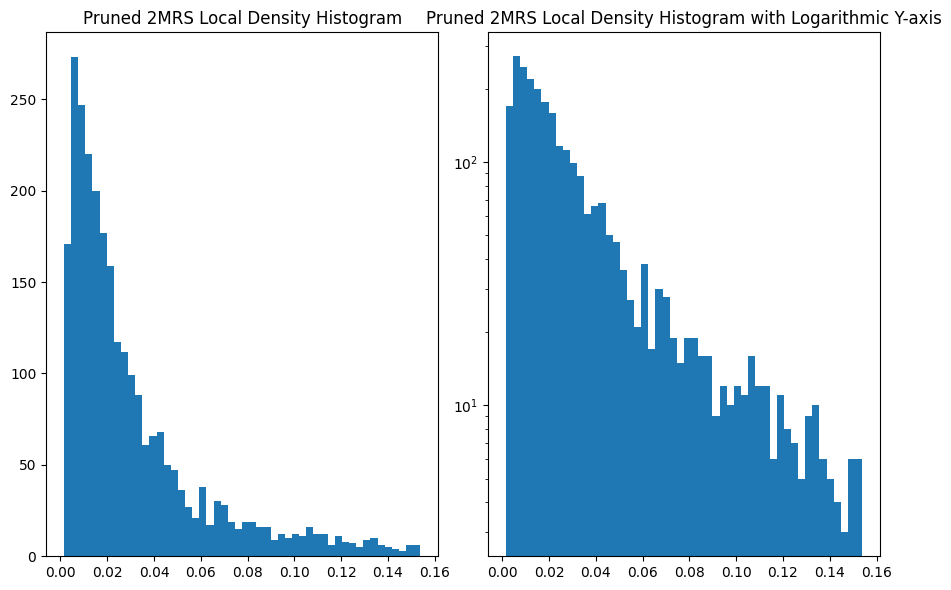

In [ ]:
###Histogram for the pruned data using the IQR method

plt.figure(figsize=(9, 6))

plt.subplot(1, 2, 1)
plt.hist(final_iqr_pruned_data['2MRS Local Density'], bins = 50)
plt.title('Pruned 2MRS Local Density Histogram')

plt.subplot(1, 2, 2)
counts, bin_edges, _  = plt.hist(final_iqr_pruned_data['2MRS Local Density'], bins = 50)
plt.yscale('log')
plt.title('Pruned 2MRS Local Density Histogram with Logarithmic Y-axis')

plt.tight_layout()
plt.show()

This looks much better! Looks like also doing log will improve the distribution, but might as well try both.

# Retraining and Evaluating Models with Pruned Data


In [ ]:
final_iqr_pruned_data.head()

,GalaxyID,RA,Dec,Redshift,2MRS Local Density,Distance From Filament,Distance From Tendril,SDSS Local Density
136,1345,183.97717,6.40111,0.00797,0.058873,40.725823,0.370381,5.816617
138,1457,184.35759,6.69003,0.00856,0.061600,38.989834,0.440810,4.468965
141,2351,184.73404,4.78598,0.00775,0.065681,41.428806,0.683665,6.734374
142,2466,185.42279,5.38483,0.00871,0.025702,38.616415,0.029979,13.975354
143,2855,185.31866,4.59568,0.00868,0.021946,38.706358,0.381642,6.548093


In [ ]:
###Creating splits

vals = final_iqr_pruned_data.values

log_data = np.copy(vals)
#print(vals[:, 4])
#print(vals[:, 7])
###Plotting SVM Results
log_data[:, 4] = np.log(vals[:, 4])  # Transforms 2MRS Local Density values
log_data[:, 7] = np.log(vals[:, 7])  # Transform SDSS Local Density values



X = log_data[:, 1:5] # RA, Dec, Redshift, & 2MRS Local Density (logged)
y = log_data[:,7] # SDSS Local Density (logged)

#print(y)

X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.20, random_state=1)

In [ ]:
###K-Fold Cross-Validation To Compare Models

# Initialize the models
models = []
models.append(('LR', LinearRegression()))
models.append(('RFR', RandomForestRegressor()))
models.append(('KNN', KNeighborsRegressor())) #default k is 5
models.append(('GBR', GradientBoostingRegressor()))
models.append(('SVM', SVR(gamma='auto')))

print('Model MAPEs:\n')
for name, model in models:
  kfold = KFold(n_splits=10, random_state=1, shuffle=True)
  cvResult = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='neg_mean_absolute_percentage_error')
  print(f'{name}: {round(-cvResult.mean(), 4)}%')

Model MAPEs:

LR: 2.0779%
RFR: 2.4952%
KNN: 2.6193%
GBR: 2.2413%
SVM: 1.8892%


These results are much, much more promising! All of the models are peforming really well, with RFR having a practically 0% mean absolute error percentage.

In [ ]:
###Predicting on "more detailed" 2MRS local density with SVM
model = SVR(gamma='auto')
model.fit(X_train, Y_train)
predictions = model.predict(X_validation)

#print(max(predictions))

#Evaluate predictions
print(f'Root Mean Squared Error: {root_mean_squared_error(Y_validation, predictions)}\n')
print(f'R^2 Score: {r2_score(Y_validation, predictions)}\n')
print(f'MAPE Score: {round(mean_absolute_percentage_error(Y_validation, predictions), 2)}%\n')

Root Mean Squared Error: 1.175689644188276

R^2 Score: 0.3407542710031549

MAPE Score: 1.54%



In [ ]:
###Predicting on "more detailed" 2MRS local density with RFR
model = RandomForestRegressor()
model.fit(X_train, Y_train)
predictions = model.predict(X_validation)

#print(max(predictions))

#Evaluate predictions
print(f'Root Mean Squared Error: {root_mean_squared_error(Y_validation, predictions)}\n')
print(f'R^2 Score: {r2_score(Y_validation, predictions)}\n')
print(f'MAPE Score: {round(mean_absolute_percentage_error(Y_validation, predictions), 4)}%\n')

Root Mean Squared Error: 1.1270560525783753

R^2 Score: 0.3941669378148672

MAPE Score: 1.5005%



The random forest regressor is peforming with almost perfect accuracy.

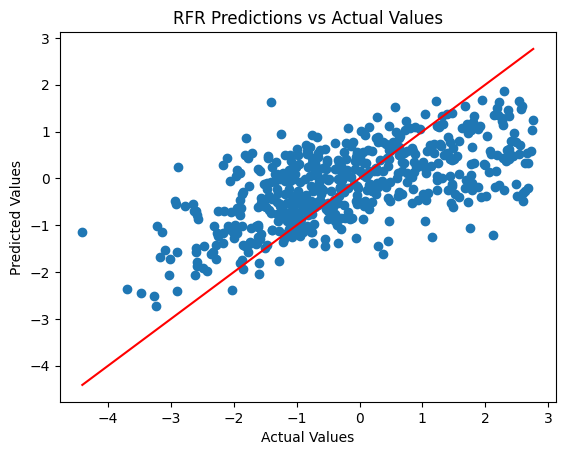

In [ ]:
###Plotting RFR Results
plt.scatter(Y_validation, predictions)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('RFR Predictions vs Actual Values')
plt.plot([min(Y_validation), max(Y_validation)], [min(Y_validation), max(Y_validation)], color='red')  # Ideal line
plt.show()

Below is to see how the model performs with the just the local density values as features.

In [ ]:
###Creating splits for only local density features

vals = final_iqr_pruned_data.values

log_data = np.copy(vals)
#print(vals[:, 4])
#print(vals[:, 7])
###Plotting SVM Results
log_data[:, 4] = np.log(vals[:, 4])  # Transforms 2MRS Local Density values
log_data[:, 7] = np.log(vals[:, 7])  # Transform SDSS Local Density values



X = log_data[:, 4] # 2MRS Local Density (logged)
y = log_data[:,7] # SDSS Local Density (logged)

X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.20, random_state=1)

#Reshape to 1D array so scikit API doesn't complain about 2D array
X_train = X_train.reshape(-1, 1)
X_validation = X_validation.reshape(-1, 1)

In [ ]:
###Predicting with SVM...
model = SVR(gamma='auto')
model.fit(X_train, Y_train)
predictions = model.predict(X_validation)

#Evaluate predictions
print(f'Root Mean Squared Error: {root_mean_squared_error(Y_validation, predictions)}\n')
print(f'R^2 Score: {r2_score(Y_validation, predictions)}\n')
print(f'MAPE Score: {round(mean_absolute_percentage_error(Y_validation, predictions), 2)}%\n')

Root Mean Squared Error: 1.3190005908678248

R^2 Score: 0.17024109992953185

MAPE Score: 1.73%



In [ ]:
###Predicting with RFR...
model = RandomForestRegressor()
model.fit(X_train, Y_train)
predictions = model.predict(X_validation)

#Evaluate predictions
print(f'Root Mean Squared Error: {root_mean_squared_error(Y_validation, predictions)}\n')
print(f'R^2 Score: {r2_score(Y_validation, predictions)}\n')
print(f'MAPE Score: {round(mean_absolute_percentage_error(Y_validation, predictions), 4)}%\n')

Root Mean Squared Error: 1.6138257801136844

R^2 Score: -0.24215341266917978

MAPE Score: 2.5158%



Now, lets also normalize the data

In [5]:
###Creating splits

vals = final_iqr_pruned_data.values

log_data = np.copy(vals)
#print(vals[:, 4])
#print(vals[:, 7])
###Plotting SVM Results
log_data[:, 4] = np.log(vals[:, 4])  # Transforms 2MRS Local Density values
log_data[:, 7] = np.log(vals[:, 7])  # Transform SDSS Local Density values



X = log_data[:, 1:5] # RA, Dec, Redshift, & 2MRS Local Density (logged)
y = log_data[:,7] # SDSS Local Density (logged)

#print(y)

X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.20, random_state=1)

In [6]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler() # better for data with outliers

# Fit and transform the data
scaler.fit(X_train)
X_train_rscaled = scaler.transform(X_train)
X_validation_rscaled = scaler.transform(X_validation)

In [8]:
###Predicting on "more detailed" 2MRS local density with SVM (with robust scaled data)
model = SVR(gamma='auto')
model.fit(X_train_rscaled, Y_train)
predictions = model.predict(X_validation_rscaled)

#print(max(predictions))

#Evaluate predictions
print(f'Root Mean Squared Error: {root_mean_squared_error(Y_validation, predictions)}\n')
print(f'R^2 Score: {r2_score(Y_validation, predictions)}\n')
print(f'MAPE Score: {round(mean_absolute_percentage_error(Y_validation, predictions), 2)}%\n')

Root Mean Squared Error: 1.3057526637247288

R^2 Score: 0.18682544605398432

MAPE Score: 1.85%



In [9]:
###Predicting on "more detailed" 2MRS local density with RFR (with robust scaled data)
model = RandomForestRegressor()
model.fit(X_train_rscaled, Y_train)
predictions = model.predict(X_validation_rscaled)

#print(max(predictions))

#Evaluate predictions
print(f'Root Mean Squared Error: {root_mean_squared_error(Y_validation, predictions)}\n')
print(f'R^2 Score: {r2_score(Y_validation, predictions)}\n')
print(f'MAPE Score: {round(mean_absolute_percentage_error(Y_validation, predictions), 2)}%\n')

Root Mean Squared Error: 1.1325990470218152

R^2 Score: 0.3881931672514717

MAPE Score: 1.43%



In [10]:
###Predicting on "more detailed" 2MRS local density with GBR (with robust scaled data)
model = GradientBoostingRegressor()
model.fit(X_train_rscaled, Y_train)
predictions = model.predict(X_validation_rscaled)

#print(max(predictions))

#Evaluate predictions
print(f'Root Mean Squared Error: {root_mean_squared_error(Y_validation, predictions)}\n')
print(f'R^2 Score: {r2_score(Y_validation, predictions)}\n')
print(f'MAPE Score: {round(mean_absolute_percentage_error(Y_validation, predictions), 2)}%\n')

Root Mean Squared Error: 1.2709670155906176

R^2 Score: 0.2295747662744465

MAPE Score: 1.68%



In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() # better for data with outliers

# Fit and transform the data
scaler.fit(X_train)
X_train_rscaled = scaler.transform(X_train)
X_validation_rscaled = scaler.transform(X_validation)

In [12]:
###Predicting on "more detailed" 2MRS local density with SVM (with robust scaled data)
model = SVR(gamma='auto')
model.fit(X_train_rscaled, Y_train)
predictions = model.predict(X_validation_rscaled)

#print(max(predictions))

#Evaluate predictions
print(f'Root Mean Squared Error: {root_mean_squared_error(Y_validation, predictions)}\n')
print(f'R^2 Score: {r2_score(Y_validation, predictions)}\n')
print(f'MAPE Score: {round(mean_absolute_percentage_error(Y_validation, predictions), 2)}%\n')

Root Mean Squared Error: 1.2971730968500623

R^2 Score: 0.19747641416717687

MAPE Score: 1.93%



In [13]:
###Predicting on "more detailed" 2MRS local density with RFR (with robust scaled data)
model = RandomForestRegressor()
model.fit(X_train_rscaled, Y_train)
predictions = model.predict(X_validation_rscaled)

#print(max(predictions))

#Evaluate predictions
print(f'Root Mean Squared Error: {root_mean_squared_error(Y_validation, predictions)}\n')
print(f'R^2 Score: {r2_score(Y_validation, predictions)}\n')
print(f'MAPE Score: {round(mean_absolute_percentage_error(Y_validation, predictions), 2)}%\n')

Root Mean Squared Error: 1.1306162935712214

R^2 Score: 0.390333377955277

MAPE Score: 1.46%



In [14]:
###Predicting on "more detailed" 2MRS local density with GBR (with robust scaled data)
model = GradientBoostingRegressor()
model.fit(X_train_rscaled, Y_train)
predictions = model.predict(X_validation_rscaled)

#print(max(predictions))

#Evaluate predictions
print(f'Root Mean Squared Error: {root_mean_squared_error(Y_validation, predictions)}\n')
print(f'R^2 Score: {r2_score(Y_validation, predictions)}\n')
print(f'MAPE Score: {round(mean_absolute_percentage_error(Y_validation, predictions), 2)}%\n')

Root Mean Squared Error: 1.2709260413164485

R^2 Score: 0.22962444042887764

MAPE Score: 1.68%



Even normalizing the data seems to not improve the results after cutting outliers and logging.

Now, I am going to try to use a function to search for more optimal hyper parameters to use.

In [ ]:
###Creating splits

vals = final_iqr_pruned_data.values

log_data = np.copy(vals)
#print(vals[:, 4])
#print(vals[:, 7])
###Plotting SVM Results
log_data[:, 4] = np.log(vals[:, 4])  # Transforms 2MRS Local Density values
log_data[:, 7] = np.log(vals[:, 7])  # Transform SDSS Local Density values



X = log_data[:, 1:5] # RA, Dec, Redshift, & 2MRS Local Density (logged)
y = log_data[:,7] # SDSS Local Density (logged)

#print(y)

X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.20, random_state=1)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Define the model
rf_model = RandomForestRegressor(random_state=42)

# Define the hyperparameters grid
param_dist = {
    'n_estimators': [100, 200, 500, 1000],  # Number of trees
    'max_depth': [5, 10, 20, None],         # Maximum depth of each tree
    'min_samples_split': [2, 5, 10, 15],    # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4, 8, 16],   # Minimum samples required at a leaf node
    'bootstrap': [True, False]              # Whether bootstrap samples are used
}

# Set up the random search with cross-validation
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings sampled
    cv=5,        # 5-fold cross-validation
    verbose=2,   # Higher value gives more messages about the progress
    random_state=42,
    n_jobs=-1    # Use all available cores
)

# Fit the random search model to your training data (replace X_train and y_train with your data)
random_search.fit(X_train, Y_train)

# Print the best parameters and the best score
print("Best Parameters:", random_search.best_params_)
print("Best CV Score:", random_search.best_score_)

# Access the best estimator
best_rf = random_search.best_estimator_

# Predict using the best model
Y_pred = best_rf.predict(X_validation)

# Evaluate your model performance on the test set
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

rmse = np.sqrt(mean_squared_error(Y_validation, Y_pred))
r2 = r2_score(Y_validation, Y_pred)
mape = mean_absolute_percentage_error(Y_validation, Y_pred) * 100

print(f"Root Mean Squared Error: {rmse}")
print(f"R^2 Score: {r2}")
print(f"MAPE Score: {mape}%")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': True}
Best CV Score: 0.33644659140765476
Root Mean Squared Error: 1.1342530236801294
R^2 Score: 0.3864049738188934
MAPE Score: 148.38972816963056%


Still not great results (actually slightly worse than the best), so let's visualize the importance of each feature.

Importances: [0.22152238 0.21611097 0.21831383 0.34405283]


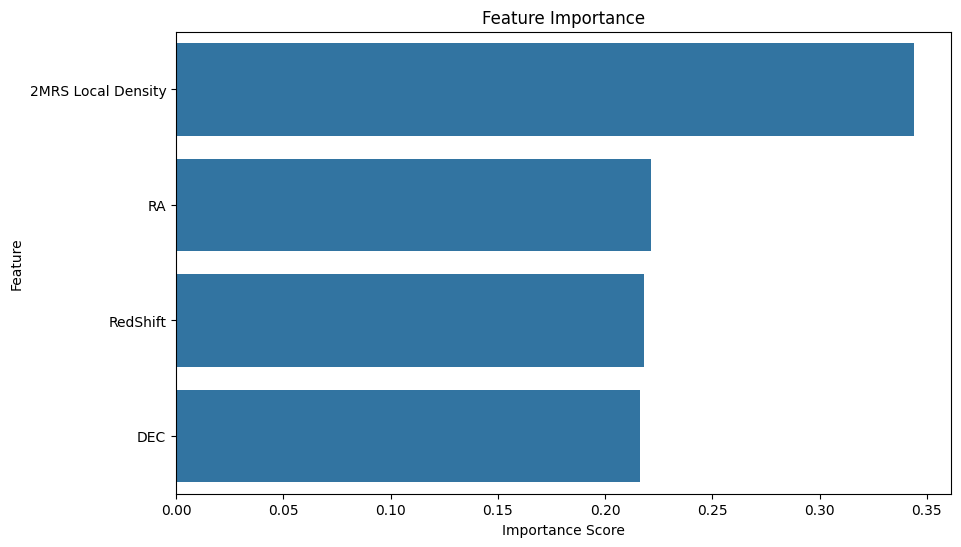

In [ ]:
import seaborn as sns

# Extract feature importances
importances = best_rf.feature_importances_

print(f'Importances: {importances}')

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': ['RA', 'DEC', 'RedShift', '2MRS Local Density'],
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()